# Single-cell-resolution differential abundance analysis

### Introduction

This notebook demonstrates how to perform differential abundance analysis at single-cell resolution.<br>
This tutorial uses the preprocessed Jak2 dataset. Please download the dataset ('PMCA_Jak2.h5ad') from our [PMCA web portal](https://gottgens-lab.stemcells.cam.ac.uk/preleukemia_atlas/).

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import meld
import sklearn
import scipy
from matplotlib import rcParams
rcParams['figure.figsize'] = (5, 5)
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

### Loading data

In [2]:
adata = sc.read('data/PMCA_Jak2.h5ad')

In [3]:
# Creating a metadata column containing replicate ID

adata.obs['replicates'] = ''

adata.obs['replicates'][adata.obs['library']=='SLX11516_SIGAB2'] = 'Jak2_Hom_rep1'
adata.obs['replicates'][adata.obs['library']=='SLX11525_SIGAB3'] = 'Jak2_Hom_rep2'
adata.obs['replicates'][adata.obs['library']=='SLX12969_SIGAB8'] = 'Jak2_Hom_rep3'
adata.obs['replicates'][adata.obs['library']=='SLX11516_SIGAC2'] = 'Jak2_WT_rep1'
adata.obs['replicates'][adata.obs['library']=='SLX11525_SIGAH2'] = 'Jak2_WT_rep2'
adata.obs['replicates'][adata.obs['library']=='SLX12969_SIGAA8'] = 'Jak2_WT_rep3'

adata.obs['replicates'] = adata.obs['replicates'].astype('category')

### Computing sample-wise cell densities

For the computation of cell densities, we use [MELD](https://www.nature.com/articles/s41587-020-00803-5).

In [4]:
X_pca = adata.obsm['X_pca']

In [5]:
# Running MELD to compute KDE
meld_op = meld.MELD(beta=15, knn=8)
sample_densities = meld_op.fit_transform(X_pca, sample_labels=adata.obs['replicates'])

Building graph on 40747 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 50.78 seconds.
  Calculating affinities...
  Calculated affinities in 2.30 seconds.
Calculated graph and diffusion operator in 53.74 seconds.


In [6]:
sample_densities

,Jak2_Hom_rep1,Jak2_Hom_rep2,Jak2_Hom_rep3,Jak2_WT_rep1,Jak2_WT_rep2,Jak2_WT_rep3
0,0.000022,0.000021,0.000023,0.000031,0.000033,0.000019
1,0.000031,0.000034,0.000036,0.000020,0.000023,0.000015
2,0.000024,0.000013,0.000025,0.000027,0.000019,0.000034
3,0.000023,0.000029,0.000027,0.000027,0.000022,0.000021
4,0.000018,0.000016,0.000020,0.000039,0.000024,0.000026
...,...,...,...,...,...,...
40742,0.000029,0.000037,0.000031,0.000020,0.000025,0.000015
40743,0.000032,0.000034,0.000030,0.000024,0.000024,0.000014
40744,0.000027,0.000019,0.000026,0.000024,0.000034,0.000020
40745,0.000020,0.000026,0.000018,0.000021,0.000027,0.000030


In [7]:
adata.obs['Jak2_Hom_rep1_KDE'] = np.array(sample_densities['Jak2_Hom_rep1'])
adata.obs['Jak2_Hom_rep2_KDE'] = np.array(sample_densities['Jak2_Hom_rep2'])
adata.obs['Jak2_Hom_rep3_KDE'] = np.array(sample_densities['Jak2_Hom_rep3'])

adata.obs['Jak2_WT_rep1_KDE'] = np.array(sample_densities['Jak2_WT_rep1'])
adata.obs['Jak2_WT_rep2_KDE'] = np.array(sample_densities['Jak2_WT_rep2'])
adata.obs['Jak2_WT_rep3_KDE'] = np.array(sample_densities['Jak2_WT_rep3'])

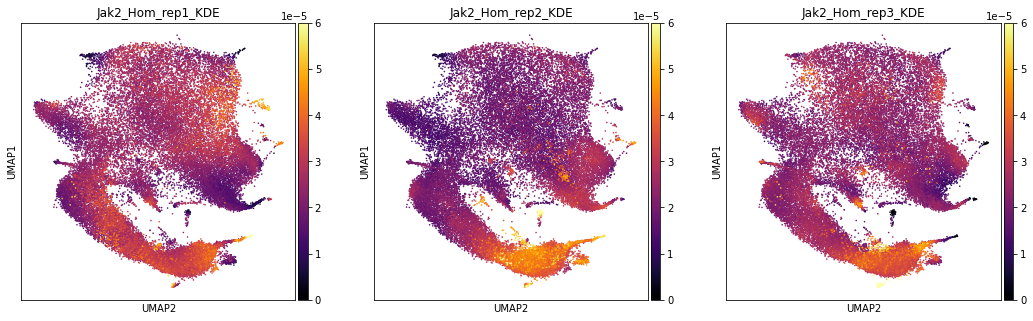

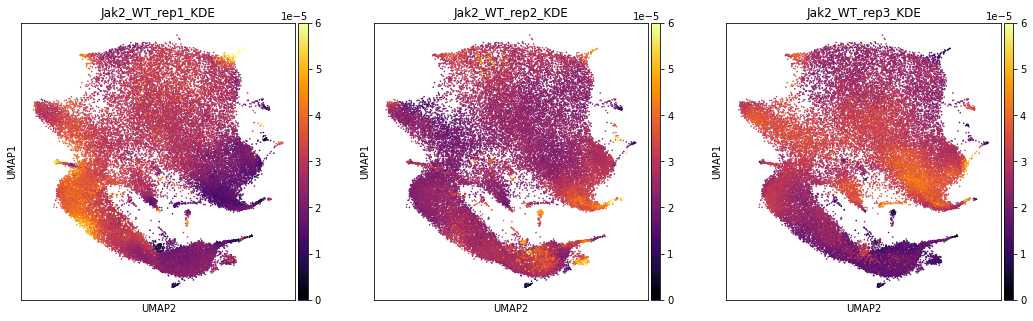

In [8]:
sc.pl.umap(adata, color=['Jak2_Hom_rep1_KDE','Jak2_Hom_rep2_KDE','Jak2_Hom_rep3_KDE'],
           components=['2,1'],s=10,cmap='inferno',vmax=6e-5,vmin=0)

sc.pl.umap(adata, color=['Jak2_WT_rep1_KDE','Jak2_WT_rep2_KDE','Jak2_WT_rep3_KDE'],
           components=['2,1'],s=10,cmap='inferno', vmax=6e-5,vmin=0)

### Pairwise density comparison

In [9]:
# L1 normalization
sample_densities['Jak2_Hom_rep1_DA'] = sklearn.preprocessing.normalize(sample_densities[['Jak2_Hom_rep1','Jak2_WT_rep1']], norm='l1')[:,0]
sample_densities['Jak2_Hom_rep2_DA'] = sklearn.preprocessing.normalize(sample_densities[['Jak2_Hom_rep2','Jak2_WT_rep2']], norm='l1')[:,0]
sample_densities['Jak2_Hom_rep3_DA'] = sklearn.preprocessing.normalize(sample_densities[['Jak2_Hom_rep3','Jak2_WT_rep3']], norm='l1')[:,0]

In [10]:
adata.obs['Jak2_Hom_rep1_DA'] = np.array(sample_densities['Jak2_Hom_rep1_DA'])
adata.obs['Jak2_Hom_rep2_DA'] = np.array(sample_densities['Jak2_Hom_rep2_DA'])
adata.obs['Jak2_Hom_rep3_DA'] = np.array(sample_densities['Jak2_Hom_rep3_DA'])

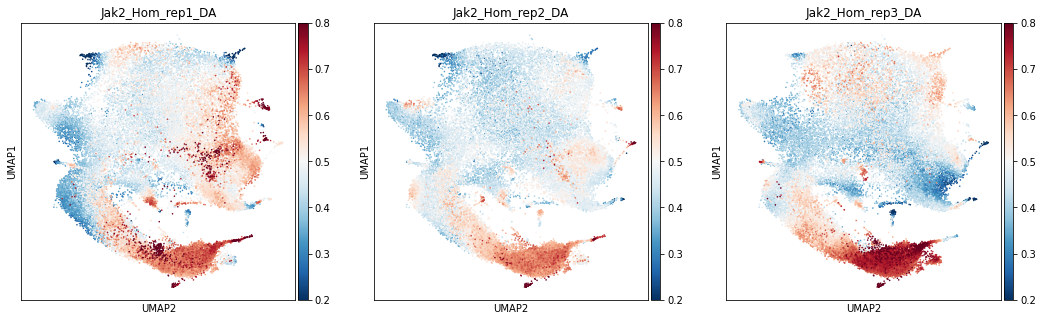

In [11]:
# Pairwise mutant relative likelihood
sc.pl.umap(adata, color=['Jak2_Hom_rep1_DA','Jak2_Hom_rep2_DA','Jak2_Hom_rep3_DA'],
           components=['2,1'],s=10,cmap='RdBu_r',vmax=.8,vmin=.2)

### Overall differential abundance landscape

In [12]:
adata.obs['mut_abundance'] = np.array(sample_densities[['Jak2_Hom_rep1_DA','Jak2_Hom_rep2_DA','Jak2_Hom_rep3_DA']].mean(axis=1))

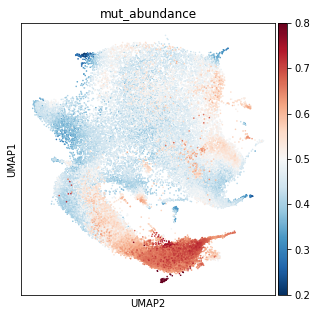

In [13]:
# Pairwise mutant relative likelihood
sc.pl.umap(adata, color=['mut_abundance'],components=['2,1'],s=10,cmap='RdBu_r', vmax=.8,vmin=.2)

### Statistical comparison of mutant and wild-type cell abundance

In [14]:
# Comparing cell densities between mutant and wild-type
pval=np.array([])

for i in sample_densities.index:
    mut_i = sample_densities.loc[i][0:3]
    wt_i = sample_densities.loc[i][3:6]
    pval_i = scipy.stats.ttest_rel(mut_i,wt_i)[1]
    pval = np.append(pval,pval_i)

In [15]:
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

In [16]:
sample_densities['pvalue'] = pval
sample_densities['p_adj'] = p_adjust_bh(pval)

In [17]:
idx_p = sample_densities['pvalue'].argsort()

In [18]:
sample_densities['sig'] = 'NonSig'

sample_densities['sig'][((sample_densities['pvalue']<0.05) & (sample_densities['p_adj']<0.25) &
                         (sample_densities[['Jak2_Hom_rep1_DA','Jak2_Hom_rep2_DA','Jak2_Hom_rep3_DA']].mean(axis=1)>0.5))] = 'Sig_high'

sample_densities['sig'][((sample_densities['pvalue']<0.05) & (sample_densities['p_adj']<0.25) &
                         (sample_densities[['Jak2_Hom_rep1_DA','Jak2_Hom_rep2_DA','Jak2_Hom_rep3_DA']].mean(axis=1)<0.5))] = 'Sig_low'

In [19]:
adata.obs['sig_mut_abundance'] = np.array(sample_densities['sig'])
adata.uns['sig_mut_abundance_colors'] = ['#d3d3d4','#b22527','#4883b7']

Trying to set attribute `.obs` of view, copying.
... storing 'sig_mut_abundance' as categorical


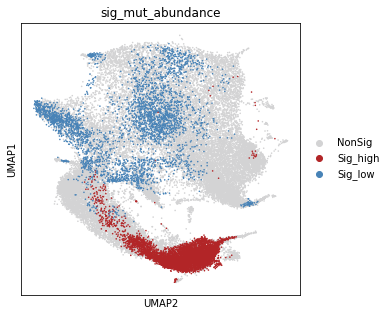

In [20]:
sc.pl.umap(adata[idx_p[::-1],:],color='sig_mut_abundance',components=['2,1'],s=10)